### Test robustness of VAE for perturbed spectra using different fudging and different segmentation

In [1]:
import os
# Set environment variables to disable multithreading as users
# will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
#########################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from anomaly.constants import GALAXY_LINES
from astroExplain.spectra.fudge import Fudge
from astroExplain.spectra.notebook import neighbors_explainer
from astroExplain.spectra.segment import SpectraSegmentation
from astroExplain.spectra.neighbors import SpectraNeighbors
from astroExplain.spectra.notebook import spectrum_in_segments
from autoencoders.ae import AutoEncoder
from anomaly.utils import specobjid_to_idx
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory

meta = MetaData()
%matplotlib inline

In [3]:
def plot_neighbor(
    wave, spectrum, neighbor, neighbor_reconstruction, figsize: tuple = (10, 9)
):

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    axs[0].plot(wave, spectrum, color="black", label="original")
    axs[0].plot(wave, neighbor, color="red", alpha=0.5, label="sample")
    axs[0].set_ylabel("Normalized flux")

    axs[1].plot(wave, spectrum, color="black", alpha=1, label="original")
    axs[1].plot(
        wave,
        neighbor_reconstruction,
        color="red",
        alpha=0.5,
        label="sample reconstruction",
    )

    axs[1].set_ylabel("Normalized flux")
    axs[1].set_xlabel("$\lambda$ [$\AA$]")

    # axs[2].plot(wave, neighbor_reconstruction, color="black", alpha=1, label="neighbor reconstruction")
    # axs[2].plot(wave, neighbor, color="red", alpha=0.6, label="neighbor")

    for ax in axs:
        ax.legend()

    return fig, axs


def show_segmentation(
    wave: np.array,
    spectrum: np.array,
    segmentation: np.array,
    number_segments: int = 100,
    figsize: tuple = (10, 6),
):

    segmenter = SpectraSegmentation()

    if segmentation == "uniform":

        segmentation_function = segmenter.uniform
        segmentation = "Uniform segmentation with"

    elif segmentation == "kmeans":

        segmentation_function = segmenter.kmeans
        segmentation = "SLIC segmentation with"

    else:
        print(f"Segmenation {segmentation} not defined")
        sys.exit()

    segments = segmentation_function(spectrum, number_segments=number_segments)
    segmented_spectrum = spectrum_in_segments(spectrum, segments)

    number_segments = np.unique(segments).size
    print(f"Number of segments: {number_segments}")

    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlabel("$\lambda$ [$\AA$]")
    ax.set_ylabel("Normalized flux")
    ax.set_title(f"{segmentation} {number_segments} segments")

    for segment in segmented_spectrum:
        ax.plot(wave, segment)

    return fig, ax

In [4]:
# config
bin_id = "bin_03"
model_id = "0021"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = (
    f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
)
explanations_directory = (
    f"{meta_data_directory}/{bin_id}/explanation/{architecture}"
)

In [35]:
# load data
wave = np.load(f"{meta_data_directory}/wave_spectra_imputed.npy")
meta_data_df = pd.read_csv(
    f"{meta_data_directory}/drop_0_01_z_0_5_4_0_snr_inf.csv.gz",
    index_col="specobjid",
)

model = AutoEncoder(reload=True, reload_from=model_directory)

spectra = np.load(
    f"{meta_data_directory}/spectra_imputed.npy", mmap_mode="r"
)

idx_id = np.load(
    f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy"
)

# load MSE score of most normal galaxies, AKA, best reconstructed ones
normal_mse_df = pd.read_csv(
    f"{explanations_directory}/mse_noRel100/top_normal.csv.gz",
    index_col="specobjid"
)
anomalous_mse_df = pd.read_csv(
    f"{explanations_directory}/mse_noRel100/top_anomalies.csv.gz",
    index_col="specobjid"
)

## Normal and anomalous spectra

score: 0.8996128875115952
score: 0.9665475234787073
score: 0.0002476051158737391


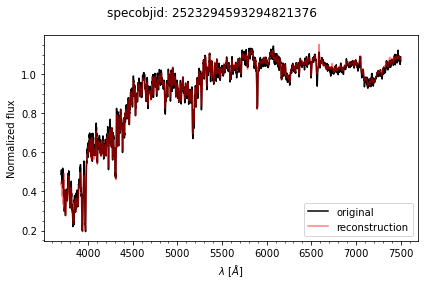

In [34]:
# Normal spectrum
specobjid = normal_mse_df.index[-1]
score = normal_mse_df.loc[specobjid, "score"]
print(f"score: {score}")

idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

reconstruction = model.reconstruct(spectrum).reshape(-1)

fig, ax = plt.subplots(tight_layout=True)  # (figsize=(10, 5))

ax.plot(wave, spectrum, color="black", label="original")

ax.plot(
    wave, reconstruction, color="red", alpha=0.5,
    label="reconstruction"
)

fig.suptitle(f"specobjid: {specobjid}")

ax.set_xlabel("$\lambda$ [$\AA$]")
ax.set_ylabel("Normalized flux")

fig.suptitle(
    # "Example of a good reconstruction\n"
    f"specobjid: {specobjid}"
)

ax.minorticks_on()
ax.legend()

save_to = "/home/edgar/explain-me-why/sections/figures/autoencoder"
fig.savefig(f"{save_to}/good_reconstruction.pdf")

score = np.abs(spectrum-reconstruction)**2
score = np.sum(score)**(0.5)
print(f"score: {score}")
score = np.abs(spectrum-reconstruction)**2
score = np.mean(score)
print(f"score: {score}")

score: 7.956200031541919
score: 7.929506136318829


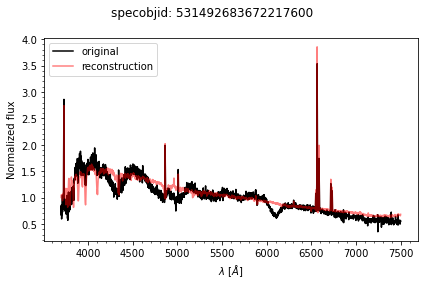

In [39]:
# Anomalous spectrum
specobjid = anomalous_mse_df.index[-355]
score = anomalous_mse_df.loc[specobjid, "score"]
print(f"score: {score}")

# specobjid = 531492683672217600
idx_spectrum = specobjid_to_idx(specobjid, idx_id)

spectrum = spectra[idx_spectrum]
reconstruction = model.reconstruct(spectrum).reshape(-1)

fig, ax = plt.subplots(tight_layout=True)  # (figsize=(10, 5))

ax.plot(wave, spectrum, color="black", label="original")
ax.plot(
    wave, reconstruction, color="red", alpha=0.5,
    label="reconstruction"
)

ax.set_xlabel("$\lambda$ [$\AA$]")
ax.set_ylabel("Normalized flux")

fig.suptitle(
    # "Example of a poor reconstruction\n"
    f"specobjid: {specobjid}"
)
ax.legend()
ax.minorticks_on()

save_to = "/home/edgar/explain-me-why/sections/figures/autoencoder"
fig.savefig(f"{save_to}/poor_reconstruction.pdf")

## Explore different fudging and segmentation

Number of segments: 65


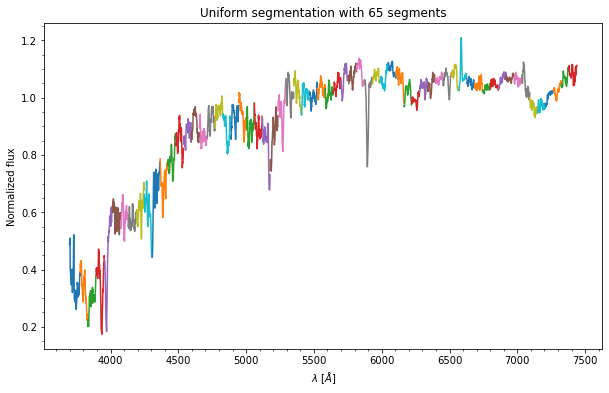

In [9]:
specobjid = normal_mse_df.index[0]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]
segmentation = "uniform"
number_segments = 64
fig, ax = show_segmentation(
    wave=wave,
    spectrum=spectrum,
    segmentation=segmentation,
    number_segments=number_segments,
    # figsize=None #(10, 5)
)
ax.minorticks_on()
save_to = (
    "/home/edgar/explain-me-why/sections/figures/"
    "lime/segmentation"
)

# fig.savefig(
#     f"{save_to}/{segmentation}_{number_segments}_{specobjid}.pdf"
# )

## Explore some archetypical spectra

In [10]:
fudge_parameters = {
    # same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.8,
    # flat
    "continuum": 1,
    # gaussians
    "amplitude": 0.2,
    "sigmas_in_segment": 8,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0.05,
}
segmentation = "kmeans"
# specobjid = 969534273977608192
# idx_spectrum = specobjid_to_idx(specobjid, idx_id)
# spectrum = spectra[idx_spectrum]
specobjid = normal_mse_df.index[0]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]
# spectrum = spectra[idx_id[-2000, 0]]
number_segments = 64
neighbors = neighbors_explainer(
    number_samples=100,
    spectrum=spectrum,
    segmentation=segmentation,
    number_segments=number_segments,
    fudge_parameters=fudge_parameters,
)
print(idx_spectrum)

Number of segments: 33
66456


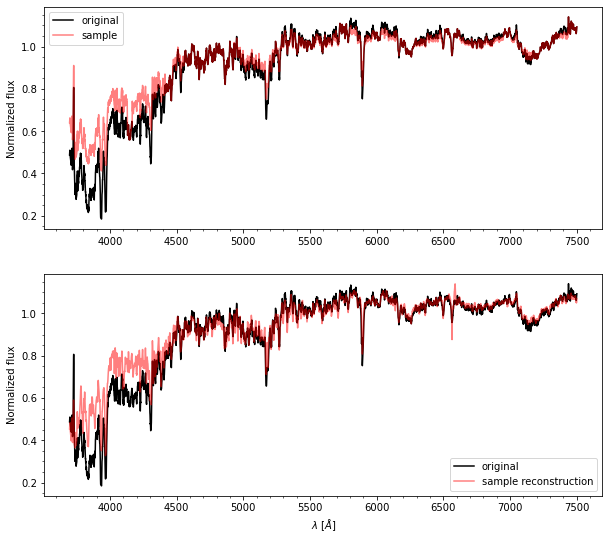

In [14]:
neighbor_id = 4
neighbor_reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plot_neighbor(
    wave,
    spectrum=neighbors[0],
    neighbor=neighbors[neighbor_id],
    neighbor_reconstruction=neighbor_reconstruction,
    # figsize=(15, 10)
)

for ax in axs: ax.minorticks_on()
# fig.suptitle(
#     "LimeSpectraexplainer Neighbor \n"
#     f"Segmentation: {segmentation} \n"
#     f"Fudging: {fudge_parameters['kind_of_fudge']}"
# )

In [12]:
fudge_parameters = {
    # same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.7,
    # flat
    "continuum": 1,
    # gaussians
    "amplitude": 1.0,
    "sigmas_in_segment": 8,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1,
}

spectrum = spectra[idx_id[-1000, 0]]
specobjid = idx_id[-1000, 1]
number_segments = 64

segmentation = "kmeans"

neighbors = neighbors_explainer(
    number_samples=100,
    spectrum=spectrum,
    segmentation=segmentation,
    number_segments=number_segments,
    fudge_parameters=fudge_parameters,
)

Number of segments: 39


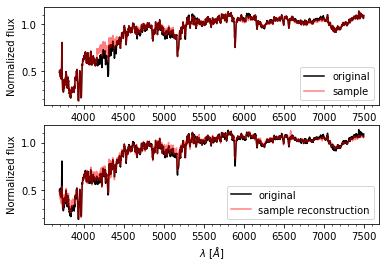

In [15]:
neighbor_id = 6
neighbor_reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plot_neighbor(
    wave,
    spectrum=neighbors[0],
    neighbor=neighbors[neighbor_id],
    neighbor_reconstruction=neighbor_reconstruction,
    figsize=None,  # (12, 9)
)

for ax in axs: ax.minorticks_on()

save_to = "/home/edgar/explain-me-why/sections/figures/lime/fudging/"
# fig.savefig(
#     f"{save_to}/{segmentation}_{number_segments}"
#     f"fudge_{fudge_parameters['kind_of_fudge']}"
#     f"{specobjid}_{neighbor_id}.pdf"
# )

## Explore some anomalies

In [49]:
fudge_parameters = {
    # same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # flat
    "continuum": 1,
    # gaussians
    "amplitude": 100.0,
    "sigmas_in_segment": 2,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0.05,
}
idx_spectrum = specobjid_to_idx(531492683672217600, idx_id)
spectrum = spectra[idx_spectrum]

number_segments = 12

neighbors = neighbors_explainer(
    number_samples=100,
    spectrum=spectrum,
    segmentation="uniform",
    number_segments=number_segments,
    fudge_parameters=fudge_parameters,
)

Number of segments: 12


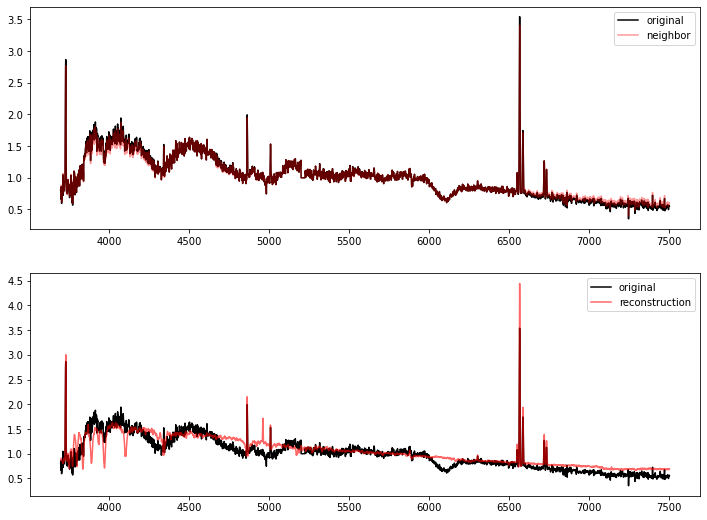

In [51]:
neighbor_id = 12
neighbor_reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plot_neighbor(
    wave,
    spectrum=neighbors[0],
    neighbor=neighbors[neighbor_id],
    neighbor_reconstruction=neighbor_reconstruction,
    figsize=(12, 9),
)